In [1]:
import os
import cv2
import numpy as np
import sys
import pickle
import time
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import socket               # Import socket module

%matplotlib inline

Using TensorFlow backend.


In [11]:
sys.setrecursionlimit(40000)

config_output_filename = 'config.pickle'

with open(config_output_filename, 'r') as f_in:
        C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

# put test data in this folder
img_path = 'data/1_shoe_only_data/forTest/'

In [3]:
def format_img(img, C):
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape
 
    if width <= height:
        f = img_min_side/width
        new_height = int(f * height)
        new_width = int(img_min_side)
    else:
        f = img_min_side/height
        new_width = int(f * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

In [16]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.iteritems()}
print(class_mapping)

colors = [(255,255,255),(255,0,0),(0,0,255),(0,0,255)]
class_to_color = {class_mapping[v]: colors[index] for index, v in enumerate(class_mapping)}

# class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
C.num_rois = int(32) # default : 32

if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (1024, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, 1024)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

{0: 'shoe', 1: 'slipper', 2: 'sandal', 3: 'bg'}


In [5]:
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

all_imgs = []

classes = {}

bbox_threshold = 0.8

visualise = True

00191.png
shoe
slipper
sandal
slipper
shoe
slipper
shoe
shoe
sandal
shoe
sandal
sandal
slipper
sandal
shoe
sandal
slipper
shoe
shoe
shoe
slipper
slipper
shoe
slipper
slipper
slipper
sandal
shoe
sandal
slipper
shoe
sandal
slipper
sandal
shoe
shoe
slipper
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
shoe
00193.png
slipper
shoe
shoe
sandal
slipper
sandal
shoe
slipper
shoe
sandal
shoe
shoe
sandal
slipper
sandal
shoe
slipper
shoe
slipper
shoe
slipper
sandal
shoe
shoe
slipper
shoe
sandal
shoe
slipper
shoe
slipper
slipper
sandal
slipper
shoe
sandal
00198.png
slipper
shoe
shoe
slipper
shoe
slipper
sandal
shoe
slipper
slipper
shoe
slipper
shoe
sandal
slipper
shoe
shoe
slipper
shoe
shoe
shoe
sandal
shoe
slipper
slipper
shoe
shoe


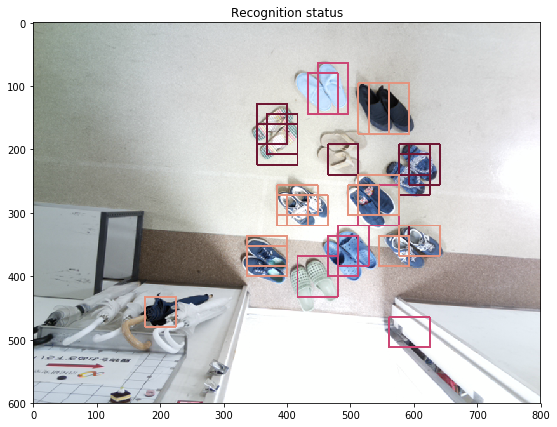

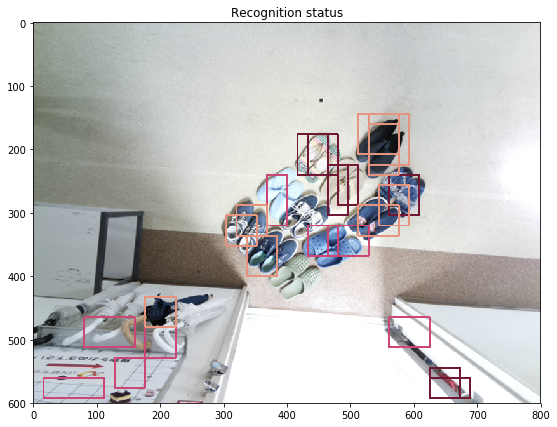

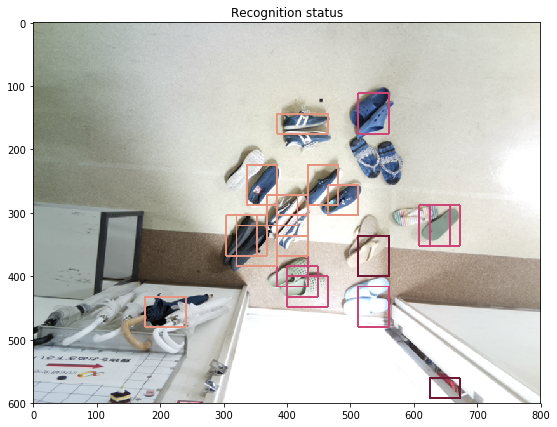

In [13]:
for idx, img_name in enumerate(sorted(os.listdir(img_path))):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(img_path,img_name)

    img = cv2.imread(filepath)
    
    X = format_img(img, C)

    img_scaled = np.transpose(X.copy()[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
    img_scaled[:, :, 0] += 123.68
    img_scaled[:, :, 1] += 116.779
    img_scaled[:, :, 2] += 103.939

    img_scaled = img_scaled.astype(np.uint8)

    if K.image_dim_ordering() == 'tf':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
            
            print(cls_name)

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16*x, 16*y, 16*(x+w), 16*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))
            
    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            cv2.rectangle(img_scaled,(x1, y1), (x2, y2), class_to_color[key],2)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (x1, y1-0)
            
            # ラベル部分を実装したい場合は使う
            # cv2.rectangle(img_scaled, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
            # cv2.rectangle(img_scaled, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            # cv2.putText(img_scaled, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
    #     print('Elapsed time = {}'.format(time.time() - st))

    #     cv2.imshow('img', img_scaled) # 'cause Gtk-WARNING **: cannot open display;

    # show image (numpy type)
    img = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2RGB)
    # print(img)

    fig1 = plt.figure(figsize = (20,20)) # create a figure with the default size 
    ax1 = fig1.add_subplot(2,2,1) 
    # imgplot = plt.imshow(img, aspect='auto')
    ax1.imshow(img, interpolation='none')
    ax1.set_title('Recognition status')
    
    plt.imshow(img)

In [ ]:
%matplotlib inline
from IPython import display
import time

listOfImageNames = ['0.png',
                    '00055.png']
for imageName in listOfImageNames:
    display.display(display.Image(filename=imageName))
    display.clear_output(wait=True)
    time.sleep(3.0)


In [17]:
def analyze_show_pic(filepath, thresh_par_bbox):

    img = cv2.imread(filepath)

    X = format_img(img, C)

    img_scaled = np.transpose(X.copy()[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
    img_scaled[:, :, 0] += 123.68
    img_scaled[:, :, 1] += 116.779
    img_scaled[:, :, 2] += 103.939

    img_scaled = img_scaled.astype(np.uint8)

    if K.image_dim_ordering() == 'tf':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.6)
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.max(P_cls[0, ii, :]) < thresh_par_bbox or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16*x, 16*y, 16*(x+w), 16*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []
    
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.3)
        count = 0
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            cv2.rectangle(img_scaled,(x1, y1), (x2, y2), class_to_color[key],2)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (x1, y1-0)

            # ラベル部分を実装したい場合は使う
#             cv2.rectangle(img_scaled, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
#             cv2.rectangle(img_scaled, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
#             cv2.putText(img_scaled, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
            
            count += 1
#         print('Elapsed time = {}'.format(time.time() - st))
    
#     # count shoe
#     count = 0
# #     for key, value in bboxes.iteritems() :
# #         print key, value
#     for key in bboxes['shoe']:
#         count = count +1
    print count
    
    # put shoe Count label
    shoeCountPosition = (50, 50)
    shoeCount = "Number of shoe=" + str(count)
    (retval,baseLine) = cv2.getTextSize(shoeCount, cv2.FONT_HERSHEY_COMPLEX,1,1)        
    cv2.rectangle(img_scaled, (shoeCountPosition[0] - 5, shoeCountPosition[1]+baseLine - 5), (shoeCountPosition[0]+retval[0] + 5, shoeCountPosition[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img_scaled, (shoeCountPosition[0] - 5,shoeCountPosition[1]+baseLine - 5), (shoeCountPosition[0]+retval[0] + 5, shoeCountPosition[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img_scaled, shoeCount, shoeCountPosition, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)


    #     cv2.imshow('img', img_scaled) # 'cause Gtk-WARNING **: cannot open display;

    # save img
    cv2.imwrite('bbimg.jpg', img_scaled)

    # display img
    display.display(display.Image(filename="bbimg.jpg"))
    display.clear_output(wait=True)

9


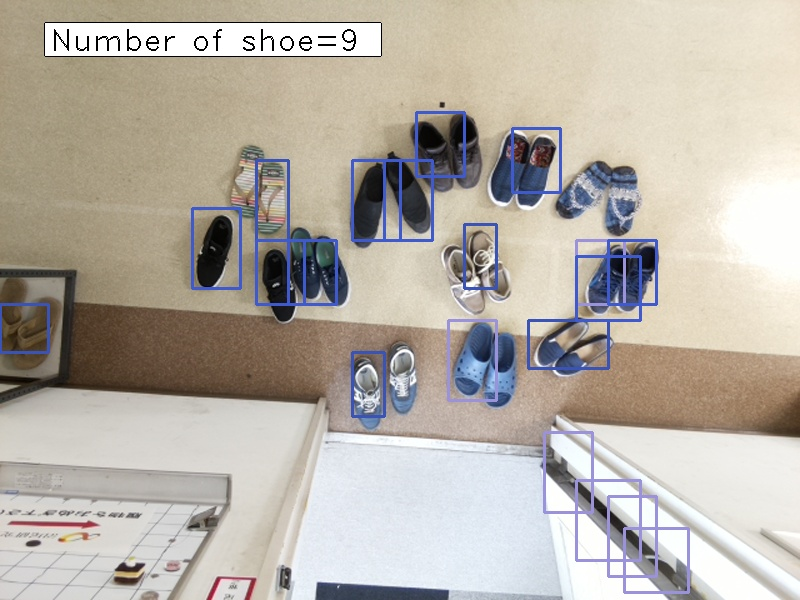

In [7]:
analyze_show_pic('latest_pic.jpg', 0.8)

10


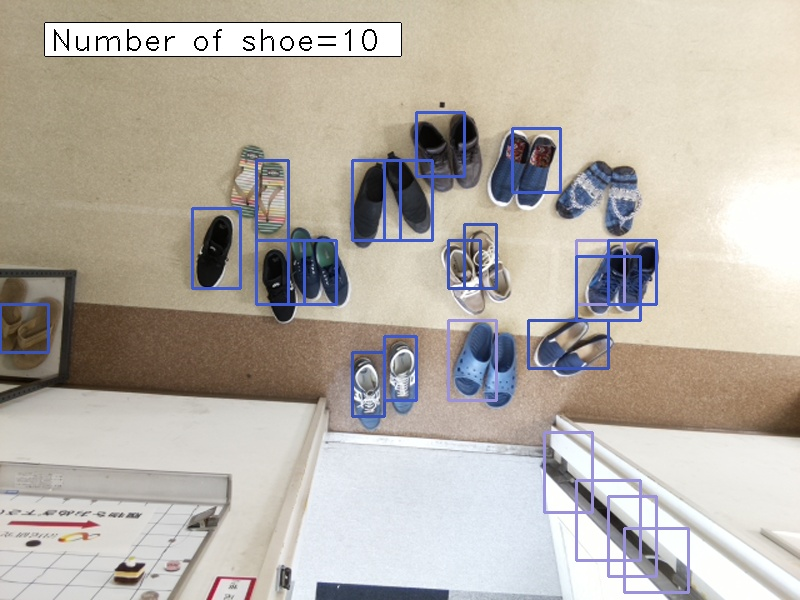

In [8]:
analyze_show_pic('latest_pic.jpg', 0.01)

# TCP socket通信でラズパイから受け取った画像にF-RCNNを適応する

In [24]:

host = ''                   # Get local machine name
port = 55000                # Reserve a port for your service.
s = socket.socket()
s.bind((host, port))        # Bind to the port
s.listen(5)                 # Now wait for client connection.
while True:
    # get latest_pic.jpg using socket connection
    c, address = s.accept()     # Establish connection with client.
    f = open('latest_pic.jpg', 'wb')
    print('Got connection from', address)
    l = c.recv(1024)
    while l:
        f.write(l)
        l = c.recv(1024)
    f.close()
    c.close()                # Close the connection
    print('closed connection')

    # analyse picture, show picture
    analyze_show_pic('latest_pic.jpg', 0.1)

KeyboardInterrupt: 

In [21]:
def analyze_show_pic_nonclear(filepath, save_pic_name, bbox_thr):

    img = cv2.imread(filepath)

    X = format_img(img, C)

    img_scaled = np.transpose(X.copy()[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
    img_scaled[:, :, 0] += 123.68
    img_scaled[:, :, 1] += 116.779
    img_scaled[:, :, 2] += 103.939

    img_scaled = img_scaled.astype(np.uint8)

    if K.image_dim_ordering() == 'tf':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.6)
    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.max(P_cls[0, ii, :]) < bbox_thr or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16*x, 16*y, 16*(x+w), 16*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []
    
    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.3)
        count = 0
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            cv2.rectangle(img_scaled,(x1, y1), (x2, y2), class_to_color[key],2)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (x1, y1-0)

            # ラベル部分を実装したい場合は使う
#             cv2.rectangle(img_scaled, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
#             cv2.rectangle(img_scaled, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
#             cv2.putText(img_scaled, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
            
            count += 1
#         print('Elapsed time = {}'.format(time.time() - st))
    
#     # count shoe
#     count = 0
# #     for key, value in bboxes.iteritems() :
# #         print key, value
#     for key in bboxes['shoe']:
#         count = count +1
    print count
    
    # put shoe Count label
    shoeCountPosition = (50, 50)
    shoeCount = "Number of shoe=" + str(count)
    (retval,baseLine) = cv2.getTextSize(shoeCount, cv2.FONT_HERSHEY_COMPLEX,1,1)        
    cv2.rectangle(img_scaled, (shoeCountPosition[0] - 5, shoeCountPosition[1]+baseLine - 5), (shoeCountPosition[0]+retval[0] + 5, shoeCountPosition[1]-retval[1] - 5), (0, 0, 0), 2)
    cv2.rectangle(img_scaled, (shoeCountPosition[0] - 5,shoeCountPosition[1]+baseLine - 5), (shoeCountPosition[0]+retval[0] + 5, shoeCountPosition[1]-retval[1] - 5), (255, 255, 255), -1)
    cv2.putText(img_scaled, shoeCount, shoeCountPosition, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)


    #     cv2.imshow('img', img_scaled) # 'cause Gtk-WARNING **: cannot open display;

    # save img
    save_name = str(save_pic_name) + ".jpg"
    cv2.imwrite(save_name, img_scaled)

    # display img
    display.display(display.Image(filename=save_name))
    display.clear_output(wait=True)

16


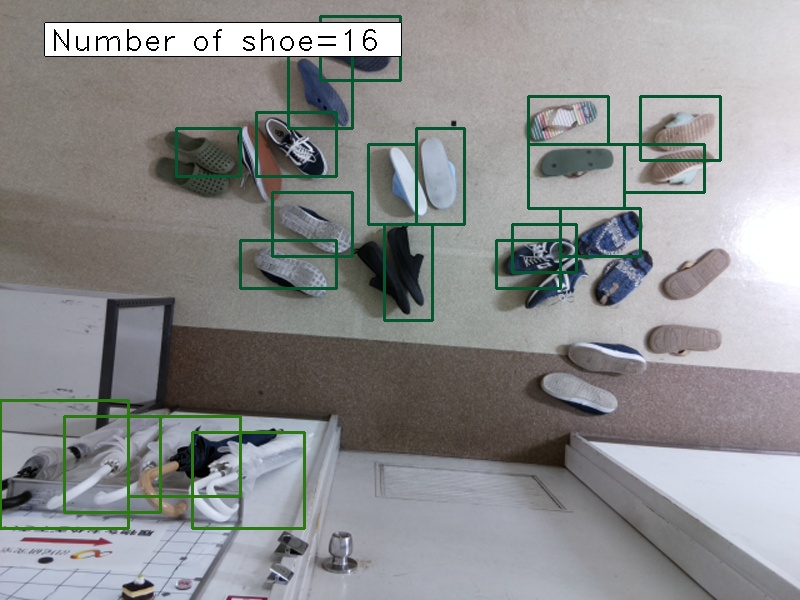

In [65]:
path = "new_data/shoesSamples/forTest/"
paths = [os.path.join(path,fn) for fn in next(os.walk(path))[2]]
print paths

count= 0
for filepath in paths:
    analyze_show_pic_nonclear(filepath, count, 0.01)
    count += 1
    
path = "new_data/shoesSamples/forTest/temp"
paths = [os.path.join(path,fn) for fn in next(os.walk(path))[2]]
print paths

for filepath in paths:
    analyze_show_pic_nonclear(filepath, count, 0.01)
    count += 1